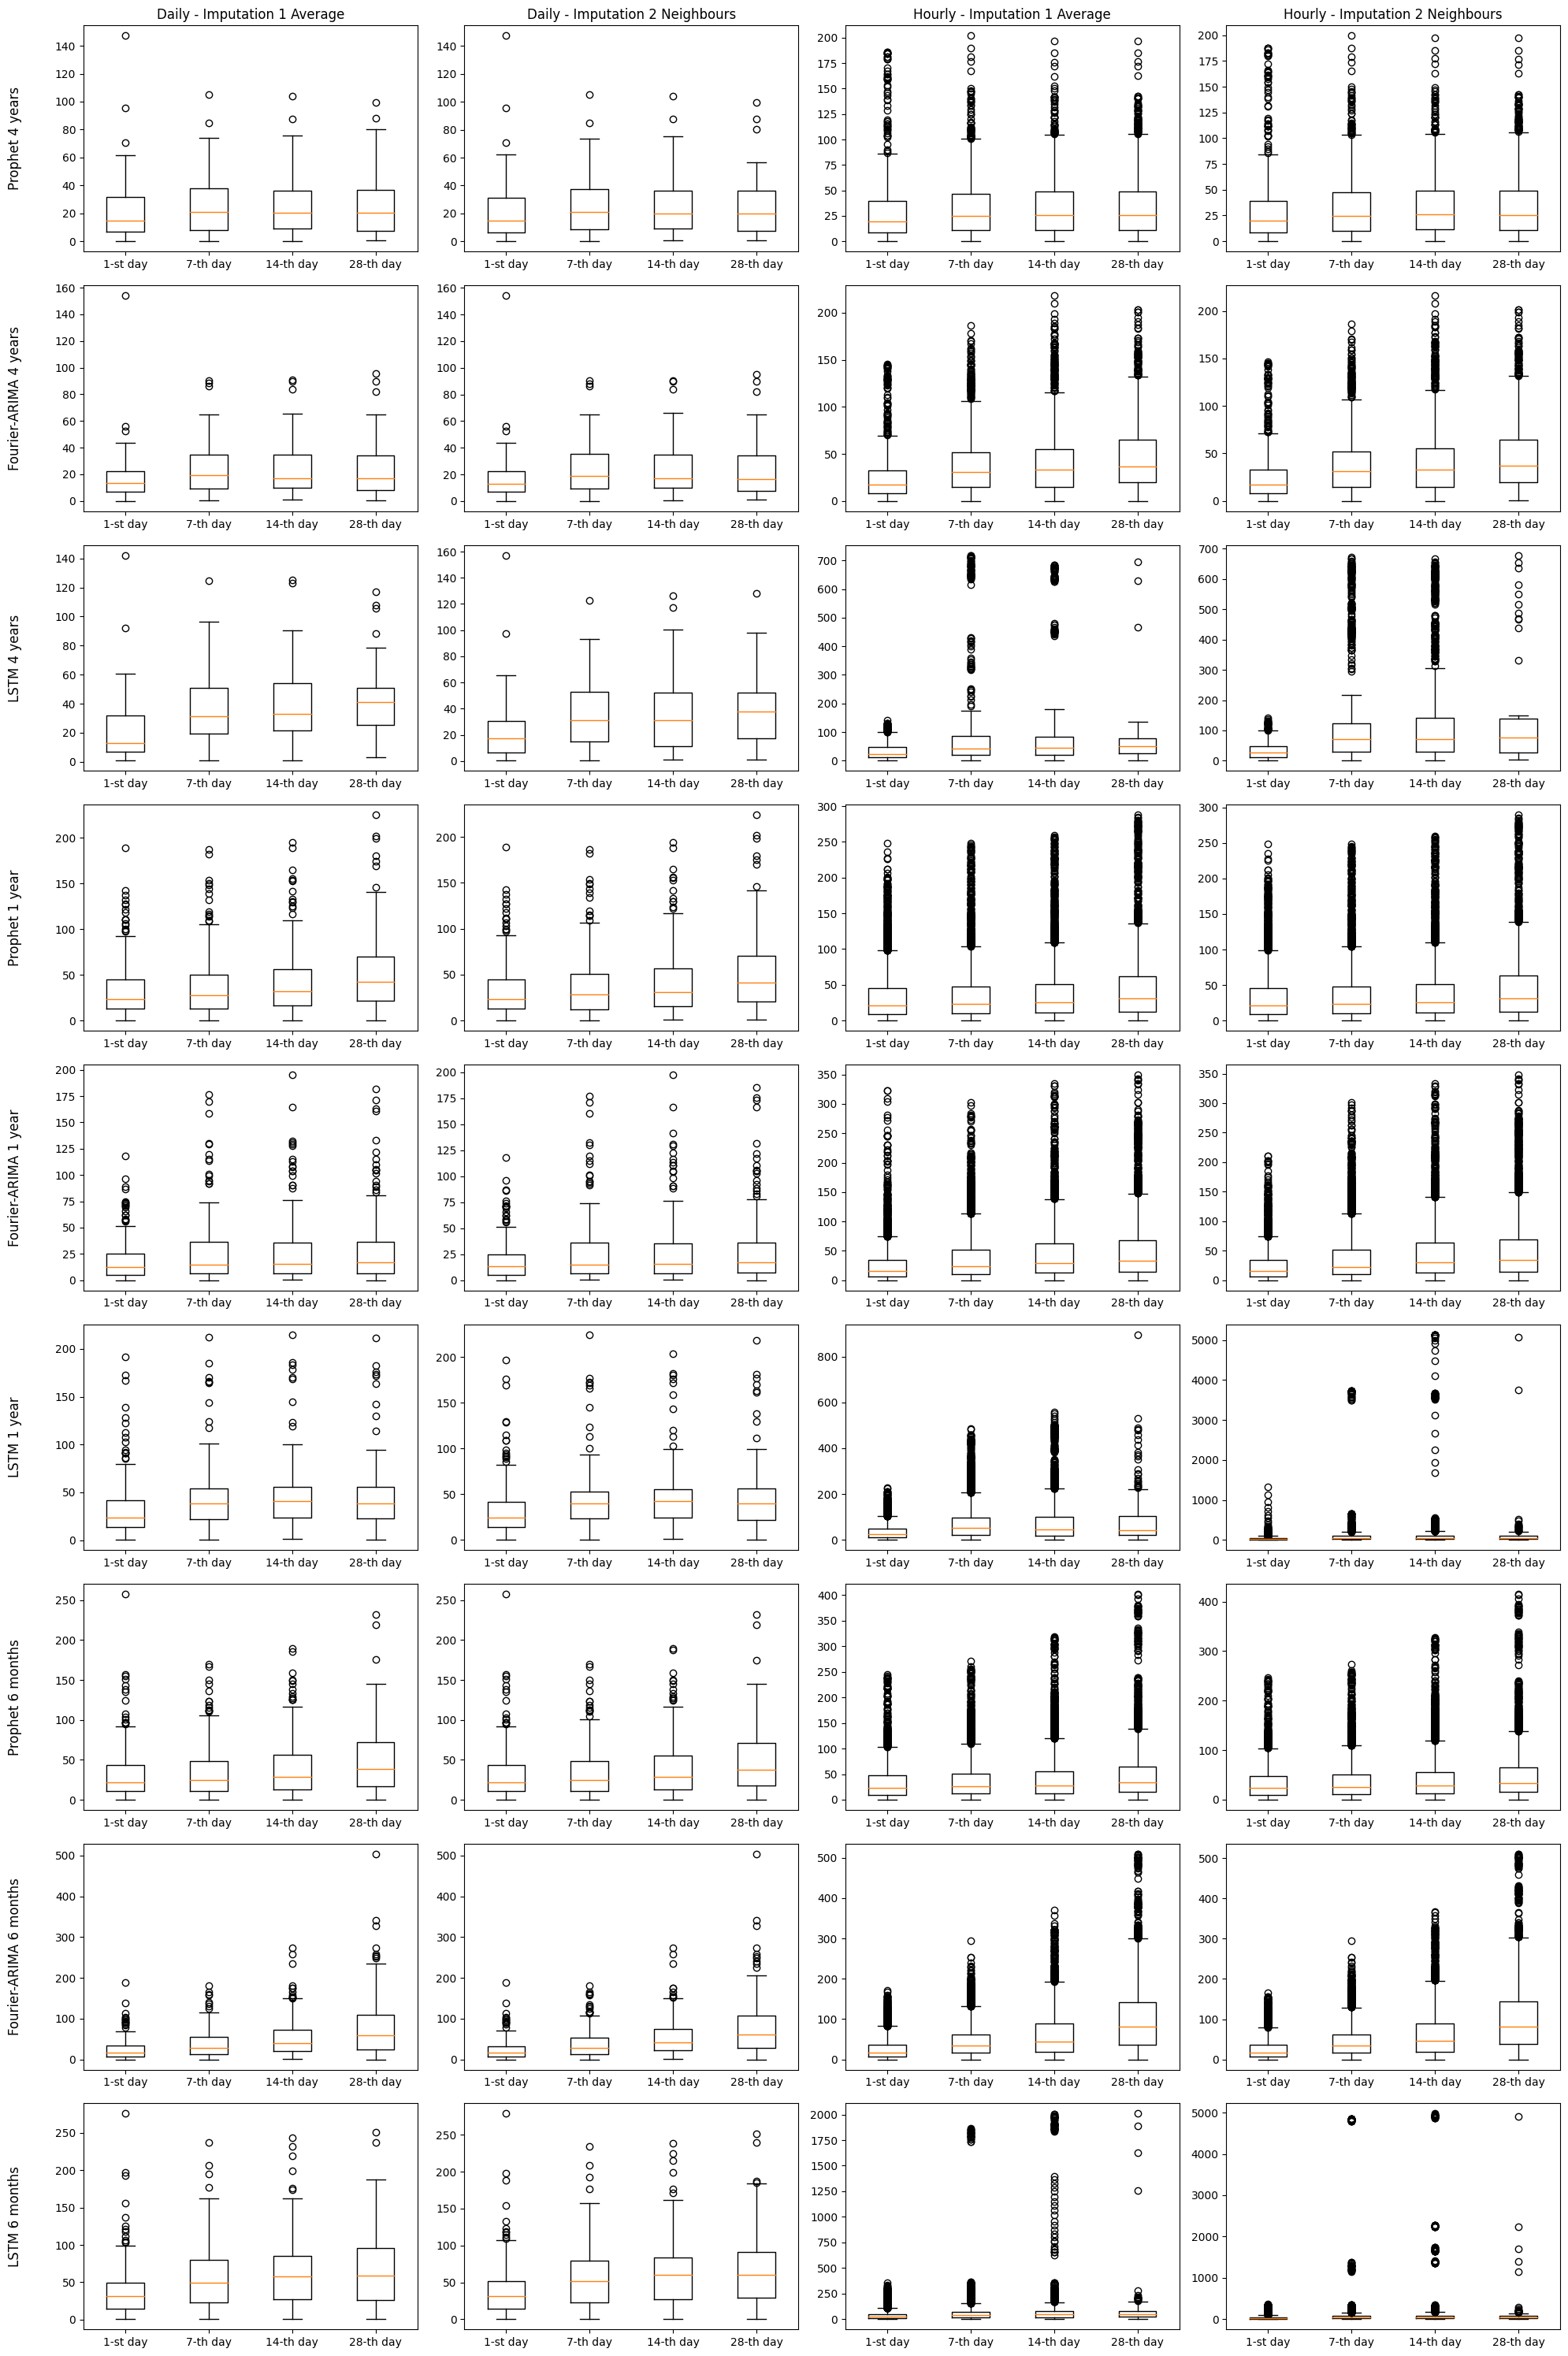

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from common_functions import *

# Experiment parameters
# train_size represents the number of months to be used for training (e.g. 4*12 is 4 years, 6 is 0.5 years)
# test_sizes represents the number of days to be used for testing (e.g. 4*7 is 4 weeks)
experiment_cases = [
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}
]



fig, axs = plt.subplots(9, 4, figsize=(20, 30))

# Add headers
header_models = ['Prophet', 'Fourier-ARIMA', 'LSTM']
header_datasets = ['Daily - Imputation 1 Average', 'Daily - Imputation 2 Neighbours', 'Hourly - Imputation 1 Average', 'Hourly - Imputation 2 Neighbours']

# Set labels for each row
for i in range(0, 9):
    if i < 3:
        train_size_label = ' 4 years'
    elif 3 <= i < 6:
        train_size_label = ' 1 year'
    else:
        train_size_label = ' 6 months'
    row_label = header_models[i % len(header_models)] + train_size_label
    axs[i, 0].set_ylabel(row_label, size='large', labelpad=30)

# Set labels for each column
for i, dataset in enumerate(header_datasets):
    axs[0, i].set_title(dataset, size='large')


# Define the mapping from filename to column index
filename_to_col = {
    "dataset_aqi_daily.csv": 0,
    "dataset_aqi_daily_filled_with_neighbors.csv": 1,
    "dataset_aqi_hourly.csv": 2,
    "dataset_aqi_hourly_filled_with_neighbors.csv": 3
}

# Define the mapping from file name to row index
file_name_to_row = {
    'Prophet_experiment_results.csv': 0,
    'ARIMA_experiment_results.csv': 1,
    'LSTM_experiment_results.csv': 2
}

# Define the mapping from train size to row offset
train_size_to_row_offset = {
    4*12: 0,
    1*12: 3,
    0.5*12: 6
}

dir_name = 'Results'
results_file_names = ['Prophet_experiment_results.csv', 'ARIMA_experiment_results.csv', 'LSTM_experiment_results.csv']


for result_file_name in results_file_names:
    results_file_path = os.path.join(dir_name, result_file_name)

    df_results = pd.read_csv(results_file_path)

    # convert to datetime
    df_results['DateTime of experiment'] = pd.to_datetime(df_results['DateTime of experiment'])
    df_results['Training data from'] = pd.to_datetime(df_results['Training data from'])
    df_results['Training data to'] = pd.to_datetime(df_results['Training data to'])
    df_results['Testing data from'] = pd.to_datetime(df_results['Testing data from'])
    df_results['Testing data to'] = pd.to_datetime(df_results['Testing data to'])
    # convert Test Data and Test Predictions to lists of doubles, LSTM has list of lists
    if 'LSTM' in result_file_name:
        df_results['Test Data'] = df_results['Test Data'].apply(lambda x: [item[0] for item in json.loads(x)])
        df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: [item[0] for item in json.loads(x)])
    else:
        df_results['Test Data'] = df_results['Test Data'].apply(lambda x: json.loads(x))
        df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: json.loads(x))
    # calculate time delta in months round to 0 decimals
    df_results['Training Duration'] = ((df_results['Training data to'] - df_results['Training data from']) / np.timedelta64(1, 'M')).round(0).astype(int)
    df_results['Testing duration'] = ((df_results['Testing data to'] - df_results['Testing data from']) / np.timedelta64(1, 'D')).round(0).astype(int)

    for experiment_case in experiment_cases:
        filename = experiment_case['filename']
        label = experiment_case['label']
        train_size = experiment_case['train_size']
        test_sizes = experiment_case['test_sizes']


        df_results_filtered = df_results[(df_results['Dataset used'] == filename) & (df_results['Label predicted'] == label) & (df_results['Training Duration'] == train_size) & (df_results['Testing duration'] == test_sizes[0])]

        # Columns that contain list of predictions for each experiment
        tests_column = df_results_filtered['Test Data']
        predictions_column = df_results_filtered['Test Predictions']

        test_data_for_periods = []
        prediction_data_for_periods = []

        # Calculating errors for 1, 7, 14, 28 days and plotting forecast plot and boxplot
        for i in [1, 7, 14, 28]:
            # take i-1-th (-1 because enumerations starts from 0) element from each list of tests and predictions columns
            if 'daily' in filename:
                tests = tests_column.apply(lambda x: x[i-1])
                predictions = predictions_column.apply(lambda x: x[i-1])
            elif 'hourly' in filename:
                tests = pd.Series([item for sublist in tests_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])
                predictions = pd.Series([item for sublist in predictions_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])

            test_data_for_periods.append(tests)
            prediction_data_for_periods.append(predictions)

        # Calculate the row and column index for the subplot
        row_index = file_name_to_row[result_file_name] + train_size_to_row_offset[train_size]
        col_index = filename_to_col[filename]

        # Plot boxplot of errors as error = abs(predictions - tests) for 1, 7, 14, 28 days on one plot where x label shows number of days
        axs[row_index, col_index].boxplot([abs(test_data_for_periods[0] - prediction_data_for_periods[0]), abs(test_data_for_periods[1] - prediction_data_for_periods[1]), abs(test_data_for_periods[2] - prediction_data_for_periods[2]), abs(test_data_for_periods[3] - prediction_data_for_periods[3])])
        axs[row_index, col_index].set_xticks([1, 2, 3, 4])
        axs[row_index, col_index].set_xticklabels(["1-st day", "7-th day", "14-th day", "28-th day"])

plt.tight_layout()      
plt.show()

In [3]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from common_functions import *

# Experiment parameters
# train_size represents the number of months to be used for training (e.g. 4*12 is 4 years, 6 is 0.5 years)
# test_sizes represents the number of days to be used for testing (e.g. 4*7 is 4 weeks)
experiment_cases = [
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}
]

# Create a DataFrame to store the errors
df_errors = pd.DataFrame(columns=['Model', 'Train Size (years)', 'Dataset', 'Error Type', '1 day', '7 days', '14 days', '28 days'])


dir_name = 'Results'
results_file_names = ['Prophet_experiment_results.csv', 'ARIMA_experiment_results.csv', 'LSTM_experiment_results.csv']

for result_file_name in results_file_names:
    results_file_path = os.path.join(dir_name, result_file_name)

    df_results = pd.read_csv(results_file_path)

    model_name = result_file_name.split('_')[0]
    if model_name == 'ARIMA':
        model_name = 'Fourier-ARIMA'

    # convert to datetime
    df_results['DateTime of experiment'] = pd.to_datetime(df_results['DateTime of experiment'])
    df_results['Training data from'] = pd.to_datetime(df_results['Training data from'])
    df_results['Training data to'] = pd.to_datetime(df_results['Training data to'])
    df_results['Testing data from'] = pd.to_datetime(df_results['Testing data from'])
    df_results['Testing data to'] = pd.to_datetime(df_results['Testing data to'])
    # convert Test Data and Test Predictions to lists of doubles
    if 'LSTM' in result_file_name:
        df_results['Test Data'] = df_results['Test Data'].apply(lambda x: [item[0] for item in json.loads(x)])
        df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: [item[0] for item in json.loads(x)])
    else:
        df_results['Test Data'] = df_results['Test Data'].apply(lambda x: json.loads(x))
        df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: json.loads(x))
    # calculate time delta in months round to 0 decimals
    df_results['Training Duration'] = ((df_results['Training data to'] - df_results['Training data from']) / np.timedelta64(1, 'M')).round(0).astype(int)
    df_results['Testing duration'] = ((df_results['Testing data to'] - df_results['Testing data from']) / np.timedelta64(1, 'D')).round(0).astype(int)

    for experiment_case in experiment_cases:
        filename = experiment_case['filename']
        label = experiment_case['label']
        train_size = experiment_case['train_size']
        test_sizes = experiment_case['test_sizes']

        dataset_name = ''
        if 'daily' in filename:
            dataset_name = 'Daily'
        elif 'hourly' in filename:
            dataset_name = 'Hourly'
        if 'neighbors' in filename:
            dataset_name += ' - Imputation 2 Neighbors'
        else:
            dataset_name += ' - Imputation 1 Average'

        df_results_filtered = df_results[(df_results['Dataset used'] == filename) & (df_results['Label predicted'] == label) & (df_results['Training Duration'] == train_size) & (df_results['Testing duration'] == test_sizes[0])]

        # Columns that contain list of predictions for each experiment
        tests_column = df_results_filtered['Test Data']
        predictions_column = df_results_filtered['Test Predictions']

        # error_dict = {'MAE': [], 'RMSE': [], 'R2': [], 'SMAPE': []}
        error_dict = {'MAE': [], 'RMSE': [], 'SMAPE': []}

        # Calculating errors for 1, 7, 14, 28 days and plotting forecast plot and boxplot
        for i in [1, 7, 14, 28]:
            # take i-1-th (-1 because enumerations starts from 0) element from each list of tests and predictions columns
            if 'daily' in filename:
                tests = tests_column.apply(lambda x: x[i-1])
                predictions = predictions_column.apply(lambda x: x[i-1])
            elif 'hourly' in filename:
                tests = pd.Series([item for sublist in tests_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])
                predictions = pd.Series([item for sublist in predictions_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])

            # Calculate errors
            mae = mean_absolute_error(tests, predictions)
            rmse = np.sqrt(mean_squared_error(tests, predictions))
            r2 = r2_score(tests, predictions)
            smape = calculate_smape(tests, predictions)

            error_dict['MAE'].append(round(mae, 2))
            error_dict['RMSE'].append(round(rmse, 2))
            # error_dict['R2'].append(r2)
            error_dict['SMAPE'].append(round(smape, 2))

        
        for error_type, errors in error_dict.items():
            df_errors = pd.concat([df_errors, pd.DataFrame({
                'Model': [model_name],
                'Train Size (years)': [train_size/12],
                'Dataset': [dataset_name],
                'Error Type': [error_type],
                '1 day': [errors[0]],
                '7 days': [errors[1]],
                '14 days': [errors[2]],
                '28 days': [errors[3]]
            })], ignore_index=True)


# Save the DataFrame to a CSV file
df_errors.to_csv('Results/errors_rounded.csv', index=False)
# Print the DataFrame as a table
# print(df_errors.to_string(index=False))